**Instituto Tecnológico de Aeronáutica – ITA**

**Visão Computacional - CM-203**

**Professores:** 

Marcos Ricardo Omena de Albuquerque Maximo

Gabriel Adriano de Melo


**Orientações padrão:**

Antes de você entregar o Lab, tenha certeza de que tudo está rodando corretamente (sequencialmente): Primeiro, **reinicie o kernel** (`Runtime->Restart Runtime` no Colab ou `Kernel->Restart` no Jupyter), depois rode todas as células (`Runtime->Run All` no Colab ou `Cell->Run All` no Jupyter) e verifique que as células rodem sem erros, principalmente as de correção automática que apresentem os `assert`s.

É muito importante que vocês não apaguem as células de resposta para preenchimento, isto é, as que contenham o `ESCREVA SEU CÓDIGO AQUI` ou o "ESCREVA SUA RESPOSTA AQUI", além das células dos `assert`, pois elas contém metadados com o id da célula para os sistemas de correção automatizada e manual. O sistema de correção automatizada executa todo o código do notebook, adicionando testes extras nas células de teste. Não tem problema vocês criarem mais células, mas não apaguem as células de correção. Mantenham a solução dentro do espaço determinado, por organização. Se por acidente acontecer de apagarem alguma célula que deveria ter a resposta, recomendo iniciar de outro notebook (ou dar um `Undo` se possível), pois não adianta recriar a célula porque perdeu o ID. Ou então você baixa e abre o notebook como texto (é um JSON) e readiciona o campo de ID. Neste ano nós também colocamos um comentário nessas células que é igual ao ID delas, para ser um failsafe em caso de sumirem com o ID das células, então NÃO apaguem esse comentário com ID (ele é um fallback caso vocês percam o ID da célula, ele deve ficar na primeira linha).

Os notebooks vocês podem alterar à vontade, podem criar novas células, modificar as existentes, apagar (a menos das células de correção). O corretor automático executará todas as células e verificará a presença de erro nos `asserts`, depois haverá a correção manual das questões com apreciação da resposta e comentários gerados em HTML. Se ele não achar a célula com os asserts, fica sem a nota da questão, se ele não achar a célular com a questão, fica sem os comentários. Mas vocês podem escreve sim código fora dos espaço delemitado pelo `ESCREVA SEU CÓDIGO AQUI` sem problemas, só não altera a assinatura da função. Esse espaço foi pensado para facilitar a sua implementação.

Os Notebooks foram programados para serem compatíveis com o Google Colab, instalando as dependências necessárias automaticamente a baixando os datasets necessários a cada Lab. Os comandos que se inicial por ! (ponto de exclamação) são de bash e também podem ser executados no terminal linux, que justamente instalam as dependências.

---

## Laboratório 3 - Neural Radiance Fields (NeRFs)

Neste laboratório iremos treinar nossa própria NeRF (Neural Radiance Field). Essa é uma reprodução simplificada do trabalho de Ben Mildenhall, Pratul P. Srinivasan, Matthew Tancik, Jonathan T. Barron, Ravi Ramamoorthi e Ren Ng entitulado [Representing Scenes as Neural Radiance Fields for View Synthesis](https://www.matthewtancik.com/nerf), no qual uma rede neural é treinada para reproduzir uma cena a partir de fotos com posições conhecidas. Essencialmente a rede neural aprende a cor e a densidade (opacidade por 'comprimento') de cada ponto X, Y, Z no espaço.

Dessa forma há diversos códigos na internet sobre esse assunto, e peço que não copiem. Podem assistir os vídeos e aulas do youtube a respeito, mas não copiem o código como resposta direta. O mesmo vale para as LLMs, não pergunte diretamente a resposta para elas, mas pode usá-las.

Esse laboratório em 5 partes, que compreendem as operações básicas com PyTorch (motivadas pelas aulas 1 e 2); o entendimento e a estruturação do conjunto de dados a ser utilizado na NeRF; a definição da arquitetura neural; o treinamento; e a inferência. Qualquer dúvida, não hesitem de perguntar no grupo do WhatsApp. Esse deve ser um Lab bem divertido e recompensador. Eu tentei simplificar ao máximo, sem que a NeRF 'parasse de funcionar'.

**ATENÇÃO**: É recomendável utilizar uma GPU Nvidia para o treinamento da NeRF neste laboratório. Habilite a GPU gratuitamente no Colab ([aula 1 slide 137](https://docs.google.com/presentation/d/1PYRArTIBh9vQ5r7DvEwGgbZp8FCkrwZnkQuFZ-z-snc)) ou utilize a imagem docker com GPU ([jupytergpu.yml](https://github.com/Gabrui/cm203)).

**Exemplo de prompt que pode ser utilizado no ChatGPT**

Pode usar LLMs desde que elas não gerem nenhum código e não falem a resposta diretamente.

Por favor, tenha cuidado para não deixá-lo falar nenhum código, senão ele vai dar a resposta de cara e você não vai aprender nada ...

```
I am a computer vision graduate student and I am currently implementing the following code. Could you help me. My professor said that you shouldn't give me the answer right away, but it is okay if you guide me towards the answer so that I can discover it by myself. You should not output any code, as requested by the professor. Here is the function I need to implement (it is in portuguese but I hope you can understand):

def entrada_senos_cossenos(x, escala=potencias_2) -> torch.Tensor:
    """ Realiza a seguinte operação em um tensor de entrada:
           x =[x1, ..., xn]
        dado um vetor de escala de frequências
           escala = [f1, f2, ..., fe]
        Calcula:
           senos = [sin(f1*x1), sin(f2*x1), ..., sin(fe*x1), ... ... ... , sin(f1*xn), sin(f2*xn), ..., sin(fe*xn)]
           cosse = [cos(f1*x1), cos(f2*x1), ..., cos(fe*x1), ... ... ... , cos(f1*xn), cos(f2*xn), ..., cos(fe*xn)]
        e retorna a concatenação do vetor de entrada e de seus senos e cossenos na escala de frequências recebida, nessa ordem.
           retorna [x, senos, cossenos]

      Args:
        x (torch.Tensor): Tensor de entrada a ser operado, tem shape (..., N)
        escala (optional, torch.Tensor): Tensor com shape (E, ) que representa os fatores de escala 
            de frequência a serem utilizados na transformação, (default: potencias_2).

      Returns:
        (torch.Tensor): Resultado da operação, tem shape (..., N + 2 * N * E)
      """

```

## Imports e Baixar dados

Temos as nossas bibliotecas conhecidas, já utilizadas nos labs 1 e 2, o NumPy e o Matplotlib. Além dessas temos o tqdm (*te quiero demasiado*) para mostrar uma barra de progresso durante o treino.

Em seguida temos a nossa estrela desse lab: O PyTorch ! Por enquanto vamos utilizá-lo em sua forma pura, mas nos próximos lab, utilizaremos o FastAI que é tem uma interface de mais alto nível. Mas é importante saber fazer as operações de mais baixo nível no PyTorch para saber como o FastAI funciona de fato. Além disso, vocês vão perceber que o PyTorch nada mais é do que o nanoGrad que fizemos na aula passado, só que glorificado: tem muito mais operações, e consegue usar GPU eficientemente.

In [25]:
from pathlib import Path
from typing import Callable, Tuple, List, Iterable
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
from torch.nn.functional import sigmoid, relu, leaky_relu, softplus, pad

import PIL

Para não ter dúvidas e nem dores de cabeça de ficar trazendo tensores de CPU para GPU e vice-versa, já definimos a GPU como o dispositivo padrão para instanciarmos nossos tensores além de nosso tipo padrão float com 32 bits.

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)
torch.set_default_dtype(torch.float32)

Verifica se já foram baixadas os dados do drive (ou do *fallback*), baixando-as e descompactando se necessário.

In [27]:
# dataset_lab read_only

! [ ! -d "/content/nerfs" ] && gdown -O /content/nerfs.zip "1VCtH2tt7h8XP8yKjYCKrIx8jQ0QiaCa-" &&  unzip -q /content/nerfs.zip -d /content && rm /content/nerfs.zip
! [ ! -d "/content/nerfs" ] && wget -P /content/ "http://ia.gam.dev/cm203/23/lab03/nerfs.zip" &&  unzip -q /content/nerfs.zip -d /content  && rm /content/nerfs.zip
base_path = Path("/content/nerfs")
%cd /content

/content


E vamos carregar os dados:

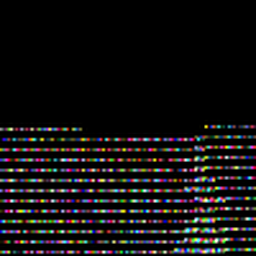

In [34]:
TRAIN = True

dados = np.load(base_path / 'dados.npz')

imagens = dados['imagens_treino']
img = Image.fromarray(imagens[1], 'RGB')
display(img.resize((256,256), PIL.Image.LANCZOS))

distancia_focal = float(dados['distancia_focal'])
imagens_treino = torch.tensor(dados['imagens_treino'])
poses_treino = torch.tensor(dados['poses_treino'])

imagens_valida = torch.tensor(dados['imagens_valida'])
poses_valida = torch.tensor(dados['poses_valida'])

## Operações Básicas PyTorch (1 ponto)

**Explicação sobre o assunto**

O pyTorch tem a mesma essência de operação que o nosso nanoGrad que implementamos na aula passada. Além disso, ele implementa todas as operações que você também consegue fazer em NumPy, sobre tudo as técnicas de slicing, broadcasting e as operações que aprendemos na aula 1 sobre o NumPy. Dessa forma temos um framework com a mesma flexibilidade de NumPy que é capaz de calcular os gradientes automaticamente além de poder operar eficientemente em GPU.

Veja com é fácil criar um tensor, lembre-se que ele é essencialmente a mesma coisa que o nosso Nó Computacional (`NoComp`) do lab passado, mas que ele também tem muito mais operações

In [5]:
torch.tensor([1, 2, 3])

tensor([1, 2, 3])

O `torch.Tensor` maiúsculo é a mesma coisa, só que ele usa o tipo especificado lá em cima como padrão (`torch.float32`) e não o tipo do dado de origem, na célula acima era int64, mas aqui já é float32.

In [6]:
torch.Tensor([1, 2, 3])

tensor([1., 2., 3.])

Você também pode criar um tensor a partir de uma matriz numpy, sendo que ele herda o tipo e o mesmo shape da matriz numpy:

In [7]:
torch.tensor(np.random.randn(4))

tensor([ 0.2271,  0.7856, -1.2149,  0.4869], dtype=torch.float64)

Quando você cria um Tensor do PyTorch inicialmente, ele não tem o cálculo dos gradientes habilitado por default, para poder habilitar esse funcionalidade, você tem que setar o parâmetro `requires_grad`, pois dessa forma, todos os tensores resultantes de um que tem isso habilitado também terá o cálculo dos gradientes habilitado. Veja que ele até aparede a `grad_fn`:

In [9]:
torch.tensor([3.1], requires_grad=True) + torch.tensor([5])

tensor([8.1000], grad_fn=<AddBackward0>)

Assim a função `backward` é responsável por implementar o `retropropaga` de todos os nós que tem `requires_grad=True`. Os gradientes ficam armazenados no atributo `.grad` dos tensores, tal qual fizemos no Lab 2:

In [10]:
tensor0 = torch.tensor([3.1], requires_grad=True)
tensor1 = 2 * tensor0 + 8
tensor1.backward()
tensor0.grad

tensor([2.])

E veja como o PyTorch te adverte quando você tenta acessar o gradiente de um tensor que não é raíz da computação (folha para ele). Isso acontece pois ele é esperto e nem guarda o gradiente para tensores intermediários pois a princípio eles não são parâmetros otimizáveis (são resultados internos de contas).

In [11]:
tensor1.grad

/usr/local/lib/python3.10/site-packages/torch/utils/_device.py:62: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:486.)
  return func(*args, **kwargs)


Mas veremos essa questão dos gradiente depois no treinamento.

Agora vamos implementar uma nova operação que será utilizada como camada inicial para a nossa NeRF, que é expandir as nossas entradas, que são simplesmente pontos 3d (X, Y, Z) em mais dimenões em frequência, isto é, aplicar senos e cossenos para obtermos uma codificação posicional (*positional encoding*) em uma dimensão maior que 3. Nas aulas futuras de Transformers, veremos mais uma outra motivação para essa operação (spoiler: é como se fosse uma codificação binária só que contínua, por exemplo se em binário representamos o número 99 como (0, 1, 1, 0,   0, 0, 1, 1) usamos os senos e cossenos com frequência exponencialmente maiores para criar uma representação contínua disso).

(E tudo isso depois do Gabriel ter falado que Deep Learning fazia um 'automatic feature engineering' sendo que temos que manualmente ajudar a rede neural com features que são senos e cossenos dos valores de entrada 🤡)

Primeiro vamos definir a quantidade de frequências que iremos utilizar e calcular os seus valores com base na exponenciação binária:

In [ ]:
qtd_frequencias = 6
potencias_2 = 2.**torch.arange(qtd_frequencias)
potencias_2

**Enunciado da Questão**

Implemente a função `entrada_senos_cossenos` abaixo. Utilize as funções `torch.sin` e `torch.cos` para aplicar o seno e o cosseno. Faça uso de operações vetorizadas, não use for-loops explícitos que poderiam ser implementados de forma vetorizada (se não depois a NeRF fica um pouco mais lenta). Veja a [aula 1 slide 100](https://docs.google.com/presentation/d/1PYRArTIBh9vQ5r7DvEwGgbZp8FCkrwZnkQuFZ-z-snc) sobre o broadcasting e também um pouco antes sobre o uso de elipsis e `None` para indexar matrizes, é a mesma coisa do NumPy no PyTorch.

**NÃO** use LLMs (ChatGPT) para pegar a resposta pronta. **NÃO** pesquise a resposta pronta na internet.

**Pode** olhar a documentação das biblitocas (PyTorch mas todas as funções que você precisa está nas **dicas**) e **pode** (aconselhado) olhar o material de aula (slides e referências).

<details><summary><b>Dica para a resposta</b></summary>
<p>
Utilize as função torch.cat e torch.flatten além de indexação com elipse e elemento None. Use índices negativos.

A minha solução ficou com três linhas (mas poderia ter sido apenas uma), pois realizei primeiro o reshape do tensor de entrada para o formato correto, depois fiz a multiplicação na dimensão correta (apenas com o operador *) e por último apliquei a concatenação dos resultados calculados com o seno e o cosseno do produto, realizando o flatten para a dimensão correta.
</p>
</details>

In [ ]:
# basico_pytorch autograded_answer

def entrada_senos_cossenos(x: torch.tensor, escala: torch.tensor = potencias_2) -> torch.tensor:
    """ Realiza a seguinte operação em um tensor de entrada usando operações VETORIZADAS.
           x =[x1, ..., xn]
        dado um vetor de escala de frequências
           escala = [f1, f2, ..., fe]
        Calcula:
           senos = [sin(f1*x1), sin(f2*x1), ..., sin(fe*x1), ... ... ... , sin(f1*xn), sin(f2*xn), ..., sin(fe*xn)]
           cosse = [cos(f1*x1), cos(f2*x1), ..., cos(fe*x1), ... ... ... , cos(f1*xn), cos(f2*xn), ..., cos(fe*xn)]
        e retorna a concatenação do vetor de entrada e de seus senos e cossenos na escala de frequências recebida, nessa ordem.
           retorna [x, senos, cossenos]

      Args:
        x (torch.Tensor): Tensor de entrada a ser operado, tem shape (..., N)
        escala (optional, torch.Tensor): Tensor com shape (E, ) que representa os fatores de escala 
            de frequência a serem utilizados na transformação, (default: potencias_2).

      Returns:
        (torch.Tensor): Resultado da operação, tem shape (..., N + 2 * N * E)
      """
    # ESCREVA SEU CÓDIGO AQUI (pode apagar este comentário, mas não apague esta célula para não perder o ID)
    raise NotImplementedError()

Se você usou uma LLM, escreva a sua conversa com ela aqui nesta própria célula de texto (copie a conversa inteira) ou exporte o link da conversa:

**Escreva aqui**

In [ ]:
# testa_basico_pytorch autograder_tests 1

qtd_frequencias = 6
potencias_2 = 2.**torch.arange(qtd_frequencias)
x0 = torch.tensor([3.])
assert entrada_senos_cossenos(x0).shape == (13,)
assert entrada_senos_cossenos(x0).dtype == torch.float32
assert entrada_senos_cossenos(x0).requires_grad == False
assert torch.linalg.norm(entrada_senos_cossenos(x0) - torch.tensor([ 3,  0.1411, -0.2794, -0.5366, -0.9056, -0.7683,  0.9836, -0.9900, 0.9602,  0.8439,  0.4242, -0.6401, -0.1804])) < 0.001
x1 = torch.tensor([[3.]])
assert entrada_senos_cossenos(x1).shape == (1, 13)
assert torch.linalg.norm(entrada_senos_cossenos(x1) - torch.tensor([[ 3,  0.1411, -0.2794, -0.5366, -0.9056, -0.7683,  0.9836, -0.9900, 0.9602,  0.8439,  0.4242, -0.6401, -0.1804]])) < 0.001
x2 = torch.tensor([[3, 1, 0.],
                   [0, 2, -1]])
assert entrada_senos_cossenos(x2).shape == (2, 39)
assert torch.linalg.norm(entrada_senos_cossenos(x2) - torch.tensor(
    [[ 3.0000,  0.1411, -0.2794, -0.5366, -0.9056, -0.7683,  0.9836, -0.9900,  0.9602,  0.8439,  0.4242, -0.6401, -0.1804,
       1.0000,  0.8415,  0.9093, -0.7568,  0.9894, -0.2879,  0.5514,  0.5403, -0.4161, -0.6536, -0.1455, -0.9577,  0.8342,
       0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000],
     [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
       2.0000,  0.9093, -0.7568,  0.9894, -0.2879,  0.5514,  0.9200, -0.4161, -0.6536, -0.1455, -0.9577,  0.8342,  0.3919,
      -1.0000, -0.8415, -0.9093,  0.7568, -0.9894,  0.2879, -0.5514,  0.5403, -0.4161, -0.6536, -0.1455, -0.9577,  0.8342]])) < 0.001
assert abs(entrada_senos_cossenos(torch.zeros(5, 2, 3)).sum().item() - 180) < 0.001
assert entrada_senos_cossenos(torch.zeros(5, 2, 7)).shape == (5, 2, 91)


## Estruturação do Conjunto de Dados (2 pontos)

**Explicação sobre o assunto**

Veja o início do vídeo abaixo, pelo menos até o primeiro minuto 01:00.

[![Video Explaining NeRFs](https://ia.gam.dev/cm203/23/lab03/nerfs_video.png)](https://youtu.be/JuH79E8rdKc "Video Explaining NeRFs - Click to Watch!")

Veja que o nosso conjunto de dados são apenas as imagens 2d tiradas de uma câmera e as poses da câmera, isto é, a posição 6d no espaço da câmera: translação (x, y, z) e rotação (os três ângulos de rotação  ψ, θ, φ por exemplo, mas essa rotação já é dada por uma matriz de rotação para não ter perigo de gimbal-lock).

Você pode se perguntar, as fotos eu consigo capturar facilmente, mas como nós conseguimos essa pose das câmeras? Isso nós veremos no próximo bimestre em visão 3d, por enquanto você pode pensar que alguém mediu essas posições antes de tirar as fotos (um braço robótico por exemplo), ou no nosso caso, com um dataset sintético que foi renderizado no Blender, é justamente as coordenadas da câmera.

Mas a ideia central da NeRF é ter uma rede neural cuja entrada é um ponto 3d no espaço, com as suas coordenadas X, Y, Z, e cuja saída é o R, G, B desse ponto e a sua 'opacidade' 𝜎 (que na realidade é uma densidade linear). <sub><sup>(OBS: Na formulação completa da NeRF, além do ponto 3d com X, Y, Z, temos os dois ângulos de visada desse ponto (θ, φ) que permite modelar o reflexo de luz (que depende de como você olha para o ponto). Mas para simplificar, deixamos de fora.)</sup></sub>

Então temos que transformar esses pixels e essa pose da câmera em uma sequência de pontos 3d no espaço que poderá servir de entrada para a rede. E depois no final, temos que pegar essa sequência de pontos e reduzir.

Vamos primeiro gerar duas matrizes de coordenadas X e Y para cada pixel da nossa imagem, chamei de `pos_x` e `pos_y`. Perceba que eles se iniciam do ponto superior esquerdo e crescem da esquerda para a direita e de cima para baixo, conforme a nossa convenção de indexação da imagem, veja por exemplo o `pos_x` abaixo:

In [ ]:
H, W = imagens_treino.shape[1:3]
pos_x, pos_y = torch.meshgrid(torch.arange(W), torch.arange(H), indexing='xy')
pos_x

Se quiser ver o `pos_y`:

In [ ]:
pos_y

Então para cada pixel, vamos pegar um vetor que sai da origem do sistema de coordenadas da câmera, tido como $(0, 0, 0)$, e passa pelo plano de formação da imagem da câmera, tido como $(x-x_c, y-y_c, f)$, onde $x_c$ e $y_c$ são o centro de formação da imagem em pixels e $f$ é a distância focal da câmera, também medida em pixels. Estamos desprezando efeitos de distorção da lente.  Essa conta que você não precisa se preocupar agora (veremos a explicação no próximo bimestre em visão 3d). <sub><sup>OBS: (Aqui a nossa implementação difere um pouco do paper, eles não deixam norma 1, apenas dividem por $f$. A diferença é que a nossa amostra de distância vai ficar um segmento de esfera, em vez de um frostum)</sup></sub>

Mas atente para o `shape` do tensor resultante: para cada pixel temos uma direção com `dir_x, dir_y, dir_z` normalizada, tudo isso no referencial da própria câmera (mas cuja direção dos eixos já foi invertida para ficar compatível com a rotação que será efetuada posteriormente).

In [ ]:
centro_x, centro_y = W / 2, H / 2
raios_camera = torch.stack([pos_x-centro_x, -(pos_y-centro_y), -distancia_focal * torch.ones_like(pos_x)], -1)
raios_camera = raios_camera / raios_camera.norm(dim=-1, keepdim=True)
raios_camera.shape

Veja que é bem semelhante ao `pos_y` acima, só que inverteu a direção, o centro ficou no meio e os valores máximos e mínimos dependem da distância focal da câmera (o FoV, Field of View, ângulo de abertura da câmera).

In [ ]:
raios_camera[:, :, 1]

Para termos um tensor com os valores de distância amostrados linearmente basta usarmos a função `torch.linspace` que a mesma do `np.linspace`.

In [ ]:
distancia_minima=2.
distancia_maxima=6.
n_amostras=64
valores_distancia = torch.linspace(distancia_minima, distancia_maxima, n_amostras)
valores_distancia

Então para cada raio normalizado nas coordenadas da câmera, iremos levá-lo para as coordenadas globais por meio da pose da câmera (é uma simples multiplicação pela matriz de rotação). Também a origem de cada um desses raios será a origem da própria câmera nas coordenadas globais (da sua pose). 

Assim, basta amostrarmos os pontos ao longo dos valores de distância da origem da câmera (já tudo em coordenadas globais).

Uma questão importante que me fez perder tempo no treinamento que não convergia muito bem da NeRF era a necessidade de perturbar a distância desses pontos, para que eles não sejam sempre os mesmos durante o treinamento, por isso temos o parâmetro aleatoriza que é o valor máximo de uma distribuição uniforme $U_{uniforme}[0, aleatoriza)$.

Assim a saída final dessa etapa de pré-processamento são os pontos 3d e também a distância entre os pontos vizinho (pois nós usaremos esse valor quando formos reduzir os pontos ao longo do raio na renderização para calcular a transparência).

Para facilitar a implementação se vocês e também o entendimento, separei a função mostrada abaixo `amostra_pontos3d` em outra `amostra_pontos3d_inner`, para detalhar melhor o seu funcionamento que você irá implementar mais a diante (só o `inner`).

In [ ]:
def amostra_pontos3d(raios_camera: torch.tensor, pose_camera: torch.tensor, valores_distancia: torch.tensor, aleatoriza: float = 0) -> Tuple[torch.tensor, torch.tensor]:
    """ Amostra pontos 3d a valores de distância ao longo do raio especificado a partir da câmera
    com a sua pose definida. Retorna esses pontos 3d e as distâncias entre eles (pontos vizinhos).

    Args:
      raios_camera (torch.Tensor): Tensor que determina o ponto de origem do raio, tem shape (..., 3)
      pose_camera (torch.Tensor): Tensor que determina a pose da câmera [R | T], tem shape (..., 3, 4)
      valores_distancia (torch.Tensor): Valores de distância entre os pontos, shape (..., n_amostras)
      aleatoriza (float): valor aleatório máximo a ser somado sobre os valores_distância

    Returns:
      (torch.Tensor): Pontos 3d amostrados, tem shape (..., n_amostras, 3)
      (torch.Tensor): Distância entre o ponto atual e o anterior, tem shape (..., n_amostras)
    """
    direcao_vetor = raios_camera @ pose_camera[..., :3, :3].T
    origem_vetor = pose_camera[..., :3, -1]
    if aleatoriza:
        valores_distancia = valores_distancia + torch.rand(direcao_vetor.shape[:-1]+valores_distancia.shape[-1:]) * aleatoriza
    return amostra_pontos3d_inner(origem_vetor, direcao_vetor, valores_distancia, 1e10)

**Enunciado da Questão**

Implemente a função `amostra_pontos3d_inner` abaixo de acordo com a sua documentação.

**NÃO** pesquise a resposta pronta na internet (**NÃO** copie o código de repositórios de NeRFs e seus derivados ...). Pode usar LLMs (ChatGPT) mas sem pedir para ele responder na cara dura, isto é, você pode pedir uma explicação mas não a resposta para a LLM, utilize por exemplo prompt de exemplo lá de cima (pode melhorar se quiser, mas nunca peça a resposta direta):

**Pode** olhar a documentação das biblitocas (NumPy, PyTorch, FastAI, mas todas as funções que você precisa está nas **dicas**) e **pode** (aconselhado) olhar o material de aula (slides e referências).

<details><summary><b>Dica para a resposta</b></summary>
<p>
Use indexação com ..., com None, com :, com número negativo. Utilize a função `pad` já importada, para acrescentar um valor (argumento value) com pad vezes no pad=(n_começo, n_final).

A minha solução ficou com duas linhas, uma para calcular os pontos3d por meio das operações de adição, multiplicação, e indexação inteligente; e a outra linha  para calcular a distância entre os pontos por meio da indexação inteligente e a função pad para acrescentar o valor_infinito no final.
</p>
</details>

In [ ]:
# estrutura_dados autograded_answer

def amostra_pontos3d_inner(origem: torch.tensor, direcao: torch.tensor, valores_distancia: torch.tensor, valor_infinito: float) -> Tuple[torch.tensor, torch.tensor]:
    """ Amostra pontos 3d a valores de distância ao longo do raio que parte de um ponto de origem
        e que tem uma direção especificada. Retorna esses pontos 3d e as distâncias entre eles (pontos vizinhos).
        Use operações VETORIZADAS.
        Observe o seguinte exemplo com as dimensões maiores omitidas (broadcastable)
           origem = [x0, y0, z0]
           direcao = [dir_x, dir_y, dir_z]
           valores_distancia = [dist0, dist1, ..., dist_n]
        Calcula:
           pontos3d = [[x0+dir_x*dist0,  y0+dir_y*dist0,  z0+dir_z*dist0],
                       [x0+dir_x*dist1,  y0+dir_y*dist0,  z0+dir_z*dist0],
                             ...              ...              ...
                       [x0+dir_x*dist_n, y0+dir_y*dist_n, z0+dir_z*dist_n]]
          distancia_entre_pontos = [dist1-dist0, dist2-dist1, ..., dist_n-dist_n1, valor_infinito]
        e retorna tanto os pontos3d quando as distância entre os pontos vizinho, sendo que o último é o valor infinito.

      Args:
        origem (torch.Tensor): Tensor que determina o ponto de origem do raio, tem shape (..., 3)
        direcao (torch.Tensor): Tensor que determina a direção do raio que parte da origem, tem norma garantidamente
            unitária, tem shape (..., 3)
        valores_distancia (torch.Tensor): Tensor que determina os valores de distância da origem que os pontos a serem
            amostrado estão (na direção do raio), tem shape (..., n_amostras)
        valor_infinito (float): Valor a ser utilizado na última distância entre pontos

      Returns:
        (torch.Tensor): Pontos 3d amostrados, tem shape (..., n_amostras, 3)
        (torch.Tensor): Distância entre o ponto atual e o anterior, tem shape (..., n_amostras)
    """
    # ESCREVA SEU CÓDIGO AQUI (pode apagar este comentário, mas não apague esta célula para não perder o ID)
    raise NotImplementedError()
    return pontos3d, distancia_entre_pontos

Se você usou uma LLM, escreva a sua conversa com ela aqui nesta própria célula de texto (copie a conversa inteira) ou exporte o link da conversa:

**Escreva aqui**

In [ ]:
# testa_estrutura_dados autograder_tests 2

pts3d_test0, dists_test0 = amostra_pontos3d_inner(torch.tensor([9, 7, 0.]), torch.tensor([0, 0, 1.]), torch.tensor([0, 1, 2, 3, 8.]), 1e9)
assert pts3d_test0.requires_grad == False
assert pts3d_test0.dtype == torch.float32
assert pts3d_test0.shape == (5, 3)
assert torch.linalg.norm(pts3d_test0 - torch.tensor([[9., 7, 0], [9, 7, 1], [9, 7, 2], [9, 7, 3], [9, 7, 8]])) < 1e-5
assert dists_test0.requires_grad == False
assert dists_test0.dtype == torch.float32
assert dists_test0.shape == (5,)
assert torch.linalg.norm(dists_test0 - torch.tensor([1, 1, 1, 5, 1e9])) < 1e-5

origem_testes = torch.tensor([0.0000, 2.7373, 2.9593])
direcao_testes = torch.tensor([
         [[ 0.3208, -0.8406, -0.4364],
          [ 0.3150, -0.8424, -0.4373],
          [ 0.3092, -0.8440, -0.4381],
          [ 0.3034, -0.8457, -0.4390]],
         [[ 0.3215, -0.8376, -0.4416],
          [ 0.3157, -0.8394, -0.4425],
          [ 0.3099, -0.8410, -0.4434],
          [ 0.3040, -0.8427, -0.4443]]])
val_dists_testes = torch.tensor([
        [[ 0.4538,  3.3146,  6.8625,  8.1907, 10.6819],
         [ 0.3811,  3.4473,  5.3367,  8.7293, 10.0798],
         [ 0.8941,  2.6826,  6.9399,  8.8870, 10.7653],
         [ 0.9996,  4.2814,  5.1150,  8.0507, 10.5449]],
        [[ 0.3916,  4.3886,  6.9209,  7.5023, 10.9344],
         [ 1.2990,  3.5211,  5.1325,  9.3391, 10.9775],
         [ 1.3107,  3.8841,  6.1250,  9.2003, 10.8153],
         [ 0.1952,  3.2972,  6.8838,  8.7427, 10.0683]]])
pts3d_test1, dists_test1 = amostra_pontos3d_inner(origem_testes, direcao_testes, val_dists_testes, 1e8)
assert pts3d_test1.dtype == torch.float32
assert pts3d_test1.shape == (2, 4, 5, 3)
assert torch.linalg.norm(pts3d_test1[:, :, [0,2,4], :] - torch.tensor([
        [[[ 0.1456,  2.3558,  2.7613],
          [ 2.2015, -3.0313, -0.0355],
          [ 3.4268, -6.2419, -1.7023]],
         [[ 0.1200,  2.4163,  2.7926],
          [ 1.6811, -1.7583,  0.6256],
          [ 3.1751, -5.7539, -1.4486]],
         [[ 0.2765,  1.9827,  2.5676],
          [ 2.1458, -3.1200, -0.0811],
          [ 3.3286, -6.3486, -1.7570]],
         [[ 0.3033,  1.8919,  2.5205],
          [ 1.5519, -1.5885,  0.7138],
          [ 3.1993, -6.1805, -1.6699]]],
        [[[ 0.1259,  2.4093,  2.7864],
          [ 2.2251, -3.0596, -0.0970],
          [ 3.5154, -6.4214, -1.8693]],
         [[ 0.4101,  1.6469,  2.3845],
          [ 1.6203, -1.5709,  0.6882],
          [ 3.4656, -6.4772, -1.8982]],
         [[ 0.4062,  1.6350,  2.3781],
          [ 1.8981, -2.4138,  0.2435],
          [ 3.3517, -6.3584, -1.8362]],
         [[ 0.0593,  2.5728,  2.8726],
          [ 2.0927, -3.0637, -0.0992],
          [ 3.0608, -5.7473, -1.5140]]]])) < 1e-3
assert dists_test1.dtype == torch.float32
assert dists_test1.shape == (2, 4, 5)
assert torch.linalg.norm(dists_test1 - torch.tensor([
        [[2.8608e+00, 3.5479e+00, 1.3282e+00, 2.4912e+00, 1.0000e+08],
         [3.0662e+00, 1.8894e+00, 3.3926e+00, 1.3505e+00, 1.0000e+08],
         [1.7885e+00, 4.2573e+00, 1.9471e+00, 1.8783e+00, 1.0000e+08],
         [3.2818e+00, 8.3360e-01, 2.9357e+00, 2.4942e+00, 1.0000e+08]],
        [[3.9970e+00, 2.5323e+00, 5.8140e-01, 3.4321e+00, 1.0000e+08],
         [2.2221e+00, 1.6114e+00, 4.2066e+00, 1.6384e+00, 1.0000e+08],
         [2.5734e+00, 2.2409e+00, 3.0753e+00, 1.6150e+00, 1.0000e+08],
         [3.1020e+00, 3.5866e+00, 1.8589e+00, 1.3256e+00, 1.0000e+08]]])) < 1e-4

pts3d, dists = amostra_pontos3d(raios_camera, poses_treino[0], valores_distancia)
assert pts3d.shape == (100, 100, 64, 3)
assert dists.shape == (64,)

Essa formulação das amostra é extremamente simplificada, o paper original realiza uma segunda amostragem baseada justamente no valor de densidade para poder amostrar os pontos de forma mais concentrada nos lugares de maior densidade (onde ele vai bater) pois não adianta nada ter um monte de pontos que ficam no vácuo, ou atrás do objeto.

Formulações mais recentes, como a [instant-NGP](https://github.com/NVlabs/instant-ngp) utiliza formas ainda mais inteligentes de amostragem e uma implementação otimizada em CUDA para deixar o treinamento ainda 100x mais rápido.

Fica a sugestão para o projeto do exame: implementar/aplicar uma NeRF original completa ou ainda modelos mais recentes de NeRFs.

## Definição da Arquitetura (3 pontos)

**Explicação sobre o assunto**

![Arquitetura da nossa Pequena NeRF a ser implementada](https://ia.gam.dev/cm203/23/lab03/nerf.png)

Neste lab implementaremos uma arquitetura menor da NeRF apresentada no artigo original (sem as entradas dos ângulos de visada) e com menor largura e profundidade.

A sua arquitetura é extremamente simples, sendo apenas camadas densas (completamente conectadas) sequenciais, a menos de uma conexão intermediária que concatena o resultado da ativação anterior com a entrada codificada.

Em PyTorch podemos definir a nossa rede neural como sendo uma `nn.Module` que apresenta algumas conviências simples de registar os parâmetros treináveis.

Abaixo, definimos uma PequenaNerf que conta com apenas 7 camadas treináveis. Escolhemos a função de ativação `leaky_relu` pois o `relu` estava ficando por muitas vezes preso em regiões negativas e não conseguia treinar (morria). Essa arquitetura tem algo interessante que é reinjetar a codificaçãoda entrada em uma camada posterior.

Nessa nossa arquitetura, temos uma entrada com tamanho 3 no último eixo que representa o ponto 3d (X, Y, Z) e uma saída com tamanho 4 (que na realidade é quebrada em 3 e 1) no último eixo que representa o valor (R, G, B, 𝜎), nessa ordem.

In [ ]:
class PequenaNerf(torch.nn.Module):
    def __init__(self,
                 largura: int = 128,
                 codificador_posicional: Callable[[torch.tensor], torch.tensor] = entrada_senos_cossenos,
                 funcao_ativacao: Callable[[torch.tensor], torch.tensor] = leaky_relu):
        super().__init__()
        self.largura = largura
        self.codificador_posicional = codificador_posicional
        self.funcao_ativacao = funcao_ativacao
        dimensoes_apos_codifica = codificador_posicional(torch.zeros(3)).shape[0]
        self.camada1 = torch.nn.Linear(dimensoes_apos_codifica, largura)
        self.camada2 = torch.nn.Linear(largura, largura)
        self.camada3 = torch.nn.Linear(largura, largura)
        self.camada4 = torch.nn.Linear(largura + dimensoes_apos_codifica, largura)
        self.camada5 = torch.nn.Linear(largura, largura)
        self.camada6 = torch.nn.Linear(largura, largura)
        self.camada_saida = torch.nn.Linear(largura, 4)
        self.camadas = [self.camada1, self.camada2, self.camada3, self.camada4, self.camada5, self.camada6, self.camada_saida]

    def forward(self, x: torch.tensor):
        return executa_rede(x, self.codificador_posicional, self.funcao_ativacao, self.camadas)

A esperteza do PyTorch com essa `nn.Module` se restringe a outros `nn.Module`s que sejam instanciados como atributos do primeiro ou ainda registrados manualmente por meio da função `.add_module`.

Perceba que tem a mesma essência do método `.parametros()` da `RedeNeuralSequencial` que foi implementada no Lab 2.

Veja por exemplo os parâmetros (que na realidade estão internos a esses módulos) que o PyTorch detecta.

In [ ]:
p = PequenaNerf()
p

Na realidade, ele consegue acessar os tensores simplesmente acessando cada módulo recursivamente e agregando os seus tensores, por exemplo, o módulo `Linear` já termina com apenas dois parâmetros `weight` e `bias` (é só a combinção linear, uma multiplicação matricial.

Veja abaixo todos os tensores que são treináveis. O `state_dict` é usado como uma forma de salvar e de carregar os parâmetros de um `nn.Module`.

In [ ]:
p.state_dict()

**Enunciado da Questão**

Implemente a função `executa_rede` abaixo de acordo com a sua documentação.

**NÃO** pesquise a resposta pronta na internet (**NÃO** copie o código de repositórios de NeRFs e seus derivados ...). Pode usar LLMs (ChatGPT) mas sem pedir para ele responder na cara dura, isto é, você pode pedir uma explicação mas não a resposta para a LLM, utilize por exemplo prompt de exemplo lá de cima (pode melhorar se quiser, mas nunca peça a resposta direta):

**Pode** olhar a documentação das biblitocas (NumPy, PyTorch, FastAI, mas todas as funções que você precisa está nas **dicas**) e **pode** (aconselhado) olhar o material de aula (slides e referências).

<details><summary><b>Dica para a resposta</b></summary>
<p>
Você deve chamar as funções, seja do codificador_posicional, seja da funcao_ativacao, ou seja um elemento da camadas_rede normalmente, tal qual chamamos as funções implementadas anteirormente, elas receber um tensor como entrada e geram um outro tensor de saída realizando diversas operações internamente, que são todas diferenciáveis e podem ser retropropagadas.

Use `torch.cat` para concatenar os valores da codificação com o da camada anterior nessa ordem. Use as função sigmoid e softplus já importadas.

Essa eu acabei levando 8 linhas para implementar, mas são todas bem simples que consistem apenas na aplicação das funções da camada (camadas_rede que é a combinação linear) seguida pela função de ativação. Você pode usar um for-loop ou descrever manualmente as operações com as camadas. Esse não tem como vetorizar pois as operações ocorrem sequencialmente e não em paralelo.
    
Um dos erros que cometi quando fui implementar pela primeira vez foi a de trocar as funções de ativação, usando uma sigmoide para a densidade, o que a limitava e deixava o trator semi-transparente. Muito atenção nessa função de ativação da última camada, isso pode prejudicar bastante o treino.
</p>
</details>

In [ ]:
# define_arquitetura autograded_answer

def executa_rede(tensor_entrada: torch.tensor, codificador_posicional: Callable, funcao_ativacao: Callable, camadas_rede: List[Callable]):
    """ Realiza a propagação direta da NeRF, que consiste primeiro na codificação da entrada (codificador_posicional)
        depois na aplicação sequencial das camadas da rede, cada qual com a sua própria combinação linear (camadas_rede)
        no qual sempre devem passar pela funcao_ativacao, a menos da última camada que deve ter uma função de ativação
        sigmoid para as três primeiras saídas e função de ativação softplus para o último elemento da saída.
        A concatenação deverá ser realizada na quarta camada interna da rede, sendo que a codificação posicional deve
        ser colocada antes do resultado da ativação da camada anterior, [x_codificado, atv_anterior] nessa ordem.

      Args:
        tensor_entrada (torch.tensor): Tensor que representa um ponto 3d no espaço, tem shape (..., 3)
        codificador_posicional (Callable): Função que computa a codificação da entrada
        funcao_ativacao (Callable): Função de ativação a ser aplicada a toda camada na rede (menos a última)
        camadas_rede (List[Callable]): Lista com 7 funções que representam a combinação linear de uma camada da rede

      Returns:
        (torch.Tensor): Saída de RGB, deve ser entre 0 e 1 (resultado de sigmoid), tem shape (..., 3)
        (torch.Tensor): Saída de densidade 𝜎, deve ser positivo (resultado de softplus), tem shape (..., )
    """
    # ESCREVA SEU CÓDIGO AQUI (pode apagar este comentário, mas não apague esta célula para não perder o ID)
    raise NotImplementedError()

Se você usou uma LLM, escreva a sua conversa com ela aqui nesta própria célula de texto (copie a conversa inteira) ou exporte o link da conversa:

**Escreva aqui**

In [ ]:
# testa_define_arquitetura autograder_tests 3

pts3d_test0 = torch.tensor([[0, 0, 0], [-999, -999, -999], [999, 999, 999.], [1, 2, 3], [-1, 8, -6]])
cores, densidades = executa_rede(pts3d_test0, lambda x: torch.cat([x, x], dim=-1), lambda x: x, [lambda x: x for i in range(6)]+[lambda x: x[..., :4]])
assert cores.dtype == torch.float32
assert cores.shape == (5, 3)
assert torch.linalg.norm(cores - torch.tensor(
        [[0.5000, 0.5000, 0.5000],
         [0.0000, 0.0000, 0.0000],
         [1.0000, 1.0000, 1.0000],
         [0.7311, 0.8808, 0.9526],
         [0.2689, 0.9997, 0.0025]])) < 1e-3
assert densidades.dtype == torch.float32
assert densidades.shape == (5,)
assert torch.linalg.norm(densidades - torch.tensor([0.69315, 0, 999, 1.3133, 0.31326])) < 1e-4

cores, densidades = executa_rede(pts3d_test0, lambda x: torch.cat([x/2, x], dim=-1), lambda x: x+1, [lambda x: x for i in range(6)]+[lambda x: x[..., :4]])
assert torch.linalg.norm(cores - torch.tensor(
        [[0.9526, 0.9526, 0.9526],
         [0.0000, 0.0000, 0.0000],
         [1.0000, 1.0000, 1.0000],
         [0.9707, 0.9820, 0.9890],
         [0.9241, 0.9991, 0.5000]])) < 1e-3
assert torch.linalg.norm(densidades - torch.tensor([3.0486, 0.0000, 1002.0000, 4.0181, 2.1269])) < 1e-4

modelo_nerf = PequenaNerf()
modelo_nerf.load_state_dict(torch.load(base_path / 'aleatoria.pt', map_location=device))
pts3d, dists = amostra_pontos3d(raios_camera[:2, :2],  poses_treino[0], torch.linspace(0, 5, 7))

cores, densidades = modelo_nerf(pts3d)
assert cores.shape == (2, 2, 7, 3)
assert cores.requires_grad == True
assert densidades.shape == (2, 2, 7)
assert densidades.requires_grad == True
assert torch.linalg.norm(cores - torch.tensor([
         [[[0.7953, 0.4961, 0.5148],
           [0.7108, 0.3646, 0.6647],
           [0.8353, 0.3493, 0.5688],
           [0.7661, 0.3283, 0.6333],
           [0.6062, 0.4618, 0.6932],
           [0.7543, 0.3719, 0.3533],
           [0.8085, 0.4326, 0.4280]],
          [[0.7953, 0.4961, 0.5148],
           [0.7006, 0.3631, 0.6645],
           [0.8324, 0.3365, 0.5950],
           [0.7625, 0.3179, 0.6299],
           [0.5739, 0.4561, 0.6880],
           [0.7773, 0.3852, 0.3391],
           [0.7382, 0.3707, 0.4519]]],
         [[[0.7953, 0.4961, 0.5148],
           [0.7031, 0.3730, 0.6575],
           [0.8291, 0.3453, 0.5678],
           [0.7587, 0.3482, 0.6528],
           [0.5746, 0.4547, 0.7069],
           [0.7038, 0.3423, 0.3991],
           [0.8258, 0.4944, 0.4465]],
          [[0.7953, 0.4961, 0.5148],
           [0.6944, 0.3735, 0.6606],
           [0.8263, 0.3322, 0.6081],
           [0.7580, 0.3278, 0.6505],
           [0.5700, 0.4707, 0.6980],
           [0.7135, 0.3595, 0.3701],
           [0.7903, 0.4171, 0.4178]]]])) < 1e-3
assert torch.linalg.norm(densidades - torch.tensor([
         [[0.1150, 0.1859, 0.1180, 0.3546, 0.3164, 0.3694, 0.2446],
          [0.1150, 0.1861, 0.1298, 0.3080, 0.3537, 0.2966, 0.2130]],
         [[0.1150, 0.1804, 0.1198, 0.3267, 0.2936, 0.3396, 0.3401],
          [0.1150, 0.1794, 0.1301, 0.2792, 0.3456, 0.3108, 0.2732]]])) < 1e-3

Pronto, se passar nos testes, a sua arquitetura está exatamente igual ao que implementamos, o que possibilita carregar os pesos já treinados e obter exatamente o mesmo resultado esperado.

Perceba que você também poderia implementar de formas diferentes e conseguir treinar uma NeRF até melhor, só que a arquitetura foi fixada por limitações da correção.

## Treinamento (2 pontos)

**Explicação sobre o assunto**

Para podermos treinar a rede neural, temos que primeiro renderizar a imagem a partir das cores e densidades de cada ponto amostrados ao longo do raio. Para isso implementamos a função `renderiza_imagem` abaixo. Ela recebe as cores e as densidades de cada ponto ao longo de um raio além das distâncias lineares entre esses pontos vizinhos, calculadas mais facilmente no passo anterior.

Como a densidade foi definida do ponto de vista da 'quantidade de matéria por elemento de profundidade' linear, nós temos que multiplicá-la justamente pela nossa distância entre os pontos vizinhos para obter uma grandeza que seja correlacionada com a opacidade do material entre esses dois pontos vizinhos. Um detalhe aqui é o uso da exponencial $(1-exp(-x))$ que garante que a opacidade esteja sempre entre 0 e 1 para valores de densidade positivos.

Depois calculamos a transmitância que a fração de luz que passa localmente entre os pontos, isto é, a transparência (o complementar da opacidade). Nós multiplicamos esse valor de transmitância consecutivamente ao longo do raio para saber o quanto de luz de chega até a câmera partindo daquele ponto por meio da função `torch.cumprod` que calcula o produto cumulativo, exemplo: `[a, b, c, d] -> [a, a*b, a*b*c, a*b*c*d]` (aqui você pode pensar equivalentemente da fração de luz que se estivesse saindo da câmera chegaria ao ponto). Para garantir que sempre pelo menos o primeiro ponto será amostrado, nós fazemos um padding com o valor unitário para ficar da forma `[1, a, a*b, a*b*c]` e o valor que seria da opacidade amostrada no infinito vai embora também.

Finalmente podemos calcula a contribuição de cada cor que é justamente a sua própria opacidade vezes o tanto de luz que chega até o observador partindo-se daquele ponto, isto é, a transmitância (transparência acumulada). Todo esse processo na realidade é uma discretização do que seria uma integral da NeRF ao longo do raio (ray).

Aqui estamos trabalhando com operações aditivas das cores ([ver slide 53 da aula 1](https://docs.google.com/presentation/d/1PYRArTIBh9vQ5r7DvEwGgbZp8FCkrwZnkQuFZ-z-snc)), só que ponderadas pela opacidade e pela 'transmitância acumulada' do ponto de interesse até a câmera. A intuição aqui é que são os pontos que emitem luz.

Ela foi dividia com a função `reduz_cores` que você implementará na célula pontuada desta seção. Atente-se para o shape dos tensores.

In [ ]:
def renderiza_imagem(cores: torch.tensor, densidades: torch.tensor, distancia_entre_pontos: torch.tensor) -> torch.tensor:
    """ Realiza a combinação das cores de acordo com a densidade do ponto ao longo do raio (ray)

      Args:
        cores (torch.Tensor): Tensor que representa a cor de um ponto no espaço em um mesmo
            raio (ray), tem shape (..., N, 3) e valores entre 0 e 1
        densidades (torch.Tensor): Tensor que representa a densidade amostrada em pontos 
            consecutivos em um raio (ray) no espaço, tem shape (..., N) e valores positivos
        distancia_entre_pontos (torch.Tensor): Tensor que representa a distância consecutiva 
            entre os pontos de um mesmo raio, tem shape (..., N)

      Returns:
        (torch.Tensor): Saída de RGB, com valores entre entre 0 e 1, tem shape (..., 3)
    """
    opacidade = 1. - torch.exp(-densidades * distancia_entre_pontos)
    transmitancia = 1 - opacidade + 1e-10
    transmitancia_acumulada = torch.cumprod(transmitancia, -1)[..., :-1]
    transmitancia_acumulada = pad(transmitancia_acumulada, (1,0), value=1)
    pesos_de_cada_cor = opacidade * transmitancia_acumulada
    return reduz_cores(cores, pesos_de_cada_cor)

**Enunciado da Questão**

Implemente as funções `reduz_cores` e `train` abaixo de acordo com a sua documentação.

**NÃO** pesquise a resposta pronta na internet (**NÃO** copie o código de repositórios de NeRFs e seus derivados ...). Pode usar LLMs (ChatGPT) mas sem pedir para ele responder na cara dura, isto é, você pode pedir uma explicação mas não a resposta para a LLM, utilize por exemplo prompt de exemplo lá de cima (pode melhorar se quiser, mas nunca peça a resposta direta):

**Pode** olhar a documentação das biblitocas (NumPy, PyTorch, FastAI, mas todas as funções que você precisa está nas **dicas**) e **pode** (aconselhado) olhar o material de aula (slides e referências).

<details><summary><b>Dica para a resposta</b></summary>
<p>
A função `reduz_cores` pode ser implementada apenas com uma linha de código. Use a função `torch.sum` somando na dimensão `dim` correta. Basta fazer uma multiplicação e uma indexação com elemento None (reshape).

A função `train` pode ser implementada com com apenas 4 linhas de código. Sendo que as três primeiras são apenas chamar as funções corretamente que foram recebidas como argumentos. Se tiver dúvida de como essas funções são chamadas, observe os testes do exercício anterior (TESTES TAMBÉM SÃO DOCUMENTAÇÃO).

É importantíssimo você chamar o método `.backward()` do seu tensor custo para poder retropropagar os gradientes, lembra do lab2 da função retropropaga?
</p>
</details>

In [ ]:
# treinamento autograded_answer

def reduz_cores(cores: torch.tensor, pesos_de_cada_cor: torch.tensor) -> torch.tensor:
    """ Realiza a média ponderada das cores ao longo do raio (ray) de acordo com a sua importância
        que já foi calculada anteriormente pela sua opacidade e pela fração da luz que chega daquele ponto.

      Args:
        cores (torch.Tensor): Tensor que representa a cor de um ponto no espaço em um mesmo raio (ray),
            tem shape (..., N, 3) e valores entre 0 e 1
        pesos_de_cada_cor (torch.Tensor): Tensor que representa os pesos a ser usado na combinação linear das
            cores consecutivas em um raio (ray) no espaço, tem shape (..., N) e valores entre 0 e 1, soma unitária

      Returns:
        (torch.Tensor): Saída de RGB da imagem formada, com valores entre entre 0 e 1, tem shape (..., 3)
    """
    # ESCREVA SEU CÓDIGO AQUI (pode apagar este comentário, mas não apague esta célula para não perder o ID)
    raise NotImplementedError()

def train(neural_model: Callable, funcao_custo: Callable, dataloader: Iterable, optimizer: torch.optim.Optimizer, scheduler: torch.optim.lr_scheduler.LRScheduler) -> List[float]:
    """ Realiza o treinamento da rede neural, 

      Args:
        neural_model (Callable): Modelo da rede neural a ser treinada
        funcao_custo (Callable): Função custo que recebe dois tensores e retorna um tensor de rank 0.
            Passe a saída esperada como primeiro argumento e a saída estimada pela rede como segundo argumento.
        dataloader (Iterable): Objeto iterável que retorna uma tupla com valores de entrada e de saída esperada
        optimizer (torch.optim.Optimizer): Tem referência os parâmetros treináveis da rede e os atualiza
        scheduler (torch.optim.lr_scheduler.LRScheduler): Controla os hiper-parâmetros do optimizer

      Returns:
        (List[float]): Lista com os custos que são MSE, mean-squared error
    """
    custos: List[float]  = []
    dataloader = tqdm(dataloader) # Para imprimir a barra de progresso verde
    for (pts3d, dists), imagem_rgb in dataloader:
        optimizer.zero_grad() # Zera os gradientes, por causa do += do lab2
        # ESCREVA SEU CÓDIGO AQUI (pode apagar este comentário, mas não apague esta célula para não perder o ID)
        raise NotImplementedError()
        optimizer.step() # Aqui que os parâmetros da rede são atualizados
        scheduler.step()
        dataloader.set_postfix(Custo=custo.item())
        custos.append(custo.item())
    return custos

Se você usou uma LLM, escreva a sua conversa com ela aqui nesta própria célula de texto (copie a conversa inteira) ou exporte o link da conversa:

**Escreva aqui**

In [ ]:
# testa_treinamento autograder_tests 2


imagem_gerada = reduz_cores(torch.tensor([[0.3, 0.8, 0.6],[0, 0, 0]]), torch.tensor([0.5, 0.5]))
assert imagem_gerada.dtype == torch.float32
assert imagem_gerada.shape == (3,)
assert torch.linalg.norm(imagem_gerada - torch.tensor([0.15, 0.4, 0.3])) < 1e-5
imagem_gerada = reduz_cores(torch.tensor([[0.3, 0.8, 0.6],[0, 0, 0]]), torch.tensor([0, 1]))
assert torch.linalg.norm(imagem_gerada - torch.tensor([0, 0., 0])) < 1e-5
imagem_gerada = reduz_cores(torch.tensor([[0.3, 0.8, 0.6],[0, 0, 0]]), torch.tensor([1, 0]))
assert torch.linalg.norm(imagem_gerada - torch.tensor([0.3, 0.8, 0.6])) < 1e-5
imagem_gerada = reduz_cores(torch.ones((55, 66, 10, 3)), torch.ones((55, 66, 10))*0.1)
assert imagem_gerada.shape == (55, 66, 3)
assert torch.linalg.norm(imagem_gerada -  torch.ones((55, 66, 3))) < 1e-5

modelo_nerf = PequenaNerf()
modelo_nerf.load_state_dict(torch.load(base_path / 'aleatoria.pt', map_location=device))
pts3d, dists = amostra_pontos3d(raios_camera[:2, :2],  poses_treino[0], torch.linspace(0, 5, 7))
cores, densidades = modelo_nerf(pts3d)
imagem_gerada = renderiza_imagem(cores, densidades, dists)
assert imagem_gerada.requires_grad == True
assert imagem_gerada.shape == (2, 2, 3)
assert torch.linalg.norm(imagem_gerada -  torch.tensor([
        [[0.7585, 0.4017, 0.5384],
         [0.7306, 0.3832, 0.5476]],
        [[0.7543, 0.4230, 0.5489],
         [0.7389, 0.4010, 0.5410]]])) < 1e-3


torch.manual_seed(42)

funcao_custo_mse = lambda ŷ, y: torch.mean((ŷ - y)**2)

amostra_pts0 = amostra_pontos3d(raios_camera, poses_treino[0], torch.linspace(2, 6, 16))
dataloader0 = [(amostra_pts0, imagens_treino[0]) for i in range(10)]

optim0 = torch.optim.Adam(modelo_nerf.parameters())
sched0 = torch.optim.lr_scheduler.OneCycleLR(optim0, 1e-3, 10)

custos = train(modelo_nerf, funcao_custo_mse, dataloader0, optim0, sched0)
assert custos[-1] <= 0.027
assert torch.linalg.norm(modelo_nerf.camada_saida.bias - torch.tensor([-0.0037, -0.0036, -0.0034, -0.0042])) < 1e-3
assert torch.linalg.norm(modelo_nerf.camada_saida.bias.grad - torch.tensor([0.0023, 0.0036, 0.0013, 0.0008])) < 1e-3
del dataloader0

Esse não foi o treinamento de verdade, foi apenas para testar o seu código (a mesma imagem 10 vezes com poucas amostras do ray). Você irá treinar de fato a NeRF mais embaixo, depois do próximo exercício pontuado.

## Validação e Síntese de Novas Cenas (2 pontos)

**Explicação sobre o assunto**

Parabéns, se você chegou até aqui é porque praticamente já está acabando a parte avaliada do lab e logo após você treinará a sua própria NeRF do zero!

Agora vamos apenas chamar a rede com as funções apropriadas que já utilizamos anteriormente.

Mas como também a inferência não faz parte do treinamento, não precisamos calcular os gradiente, o que economiza memória, assim usamos a função `torch.no_grad()` para desabilitar o cálculo dos gradientes dentro de um escopo:

In [ ]:
t0 = torch.tensor([3.], requires_grad=True)
with torch.no_grad():
    t1 = 2*t0 + 9
t1, t1.requires_grad

**Enunciado da Questão**

Implemente as funções `sintetiza_nova` de acordo com a sua documentação.

**NÃO** pesquise a resposta pronta na internet (**NÃO** copie o código de repositórios de NeRFs e seus derivados ...). Pode usar LLMs (ChatGPT) mas sem pedir para ele responder na cara dura, isto é, você pode pedir uma explicação mas não a resposta para a LLM, utilize por exemplo prompt de exemplo lá de cima (pode melhorar se quiser, mas nunca peça a resposta direta):

**Pode** olhar a documentação das biblitocas (NumPy, PyTorch, FastAI, mas todas as funções que você precisa está nas **dicas**) e **pode** (aconselhado) olhar o material de aula (slides e referências).

<details><summary><b>Dica para a resposta</b></summary>
<p>

A função `train` pode ser implementada com com apenas 4 linhas de código. Sendo que são apenas chamar as funções corretamente que foram implementada anteriormente. Não se esqueça do `torch.no_grad()`

</p>
</details>

In [ ]:
# validacao_sintese autograded_answer

def sintetiza_nova(modelo_nerf: Callable, raios_camera: torch.tensor, pose_camera: torch.tensor, valores_distancias: torch.tensor) -> torch.tensor:
    """ Amostra pontos 3d a valores de distância ao longo do raio especificado a partir da câmera
    com a sua pose definida. Retorna esses pontos 3d e as distâncias entre eles (pontos vizinhos).

    Args:
      modelo_nerf (Callable): Rede Neural
      raios_camera (torch.Tensor): Tensor que determina o ponto de origem do raio, tem shape (..., 3)
      pose_camera (torch.Tensor): Tensor que determina a pose da câmera [R | T], tem shape (..., 3, 4)
      valores_distancia (torch.Tensor): Valores de distância entre os pontos, shape (..., n_amostras)

    Returns:
        (torch.Tensor): Saída de RGB, com valores entre entre 0 e 1, tem shape (..., 3)
    """
    # ESCREVA SEU CÓDIGO AQUI (pode apagar este comentário, mas não apague esta célula para não perder o ID)
    raise NotImplementedError()

Se você usou uma LLM, escreva a sua conversa com ela aqui nesta própria célula de texto (copie a conversa inteira) ou exporte o link da conversa:

**Escreva aqui**

In [ ]:
# testa_validacao_sintese autograder_tests 2


modelo_nerf = PequenaNerf()
modelo_nerf.load_state_dict(torch.load(base_path / 'treinada.pt', map_location=device))
n_amostras0 = 256 # Diminua essa linha se a sua GPU reclamar de memória
img0 = sintetiza_nova(modelo_nerf, raios_camera, poses_valida[1], torch.linspace(2, 6, n_amostras0))
assert img0.requires_grad == False
assert img0.shape == (H, W, 3)
assert torch.linalg.norm(img0[50:55, 50:55] - torch.tensor([
        [[0.2988, 0.2144, 0.0685],
         [0.3396, 0.2407, 0.0739],
         [0.3654, 0.2630, 0.0777],
         [0.3996, 0.2907, 0.0830],
         [0.4343, 0.3110, 0.0801]],
        [[0.3106, 0.2353, 0.0742],
         [0.3208, 0.2316, 0.0709],
         [0.3539, 0.2520, 0.0723],
         [0.3644, 0.2723, 0.0739],
         [0.3935, 0.2955, 0.0727]],
        [[0.3630, 0.2703, 0.0834],
         [0.3621, 0.2685, 0.0743],
         [0.3768, 0.2754, 0.0747],
         [0.3994, 0.2906, 0.0766],
         [0.3657, 0.2873, 0.0737]],
        [[0.3786, 0.2704, 0.0733],
         [0.3903, 0.2794, 0.0764],
         [0.4062, 0.2888, 0.0841],
         [0.4312, 0.3090, 0.0858],
         [0.4103, 0.3089, 0.0849]],
        [[0.3643, 0.2552, 0.0677],
         [0.3884, 0.2796, 0.0762],
         [0.4132, 0.2855, 0.0860],
         [0.4202, 0.3040, 0.0951],
         [0.4596, 0.3417, 0.1223]]]
)) < 0.2

A imagem resultante deve ser parecida com a segunda imagem abaixo do conjunto de validação.

In [ ]:
plt.imshow(img0.cpu())

## Juntando tudo e treinando de verdade!

Vamos dar uma olhada no nosso conjunto de treinamento, são 100 imagens com o tamanho de 100 pixels de altura e largura de um trator lego:

In [ ]:
if TRAIN:
    fig, axs = plt.subplots(10, 10, figsize=(12,12))
    for ax, img in zip(axs.flatten(), imagens_treino.cpu().numpy()):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
imagens_treino.shape

Já as imagens de validação são apenas 5 (poderiam ter tido mais, mas acabou sendo uma limitação desse dataset que já peguei formatado):

In [ ]:
if TRAIN:
    fig, axs = plt.subplots(1, 6, figsize=(18,6))
    for ax, img in zip(axs.flatten(), imagens_valida.cpu().numpy()):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

E se fôssemos visualizar a saída de nossa rede:

In [ ]:
def mostra_predicao_valida(modelo_nerf, n_amostras = 128, plots = None):
    valores = torch.linspace(2, 6, n_amostras)
    fig, axs = plt.subplots(1, 6, figsize=(12,3))
    for i, ax in enumerate(axs.flatten()):
        if plots is not None and i == 5:
            plt.plot(plots, 'x-')
            break
        img = sintetiza_nova(modelo_nerf, raios_camera, poses_valida[i], valores)
        ax.imshow(img.cpu())
        ax.set_title('PSNR %.4f'%(-10 * torch.log10(torch.nn.functional.mse_loss(img, imagens_valida[i])).item()))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

if TRAIN:
    mostra_predicao_valida(modelo_nerf)

Então só para juntar todas as contas que tinham ficadas espalhadas pelas questões do notebook temos essa classe do Dataset, que gera a entrada e a saída esperada para a rede neural da NeRF.

In [ ]:
class Dataset:
    def __init__(self, imagens, poses, focal, valores_distancias):
        self.imagens = imagens
        self.poses = poses
        self.focal = focal
        self.valores_distancias = valores_distancias
        self.aleatoriza = (valores_distancias.max().item() - valores_distancias.min().item()) / len(valores_distancias)
        H, W = imagens_treino.shape[1:3]
        pos_x, pos_y = torch.meshgrid(torch.arange(W), torch.arange(H), indexing='xy')
        centro_x, centro_y = W / 2, H / 2
        raios_camera = torch.stack([pos_x-centro_x, -(pos_y-centro_y), -focal * torch.ones_like(pos_x)], -1)
        self.raios_camera = raios_camera / raios_camera.norm(dim=-1, keepdim=True)

    def dataloaders(self, batch_size=1):
        return torch.utils.data.DataLoader(self, batch_size=batch_size)
    
    def __len__(self):
        return len(self.imagens)
    
    def __getitem__(self, idx):
        if idx > len(self.imagens):
            raise IndexError("Index out of range")
        pts3d_dists = amostra_pontos3d(self.raios_camera, self.poses[idx], self.valores_distancias, self.aleatoriza)
        return pts3d_dists, self.imagens[idx]

Então vamos instanciar o nosso dataset de treino e o nosso dataloader, lembra do lab1? Aqui o dataloader simplesmente aglutinaria várias imagens para formar um tamanho de batch maior.

In [ ]:
dataset_treino = Dataset(imagens_treino, poses_treino, distancia_focal, torch.linspace(2, 6, 64))
dataloader_treino = dataset_treino.dataloaders()

Assim podemos instanciar o modelo e carregar pesos aleatórios (só porque o PyTorch gosta de iniciar os bias com valores aleatórios e eu gosto de zeros, além do desvio padrão dos pesos um pouco maior).

In [ ]:
if TRAIN:
    modelo_nerf = PequenaNerf()
    modelo_nerf.load_state_dict(torch.load(base_path/'aleatoria.pt', map_location=device))

Veja como é o modelo aleatório:

In [ ]:
if TRAIN:
    mostra_predicao_valida(modelo_nerf)

E agora fazemos o loop final do treinamento, sinta-se a vontade para ficar treinando mais e ver como os resultados evoluem, altere a quantidade de épocas e lembre-se de diminuir a learning_rate se você for rodar novamente por mais épocas.

In [ ]:
epocas = 10
learning_rate = 2e-3

optim0 = torch.optim.Adam(modelo_nerf.parameters())
sched0 = torch.optim.lr_scheduler.OneCycleLR(optim0, learning_rate, epochs=epocas, steps_per_epoch=len(dataloader_treino), pct_start=0.01)
psnrs = []

for epoca in range(epocas):
  if TRAIN:
    custos = train(modelo_nerf, torch.nn.functional.mse_loss, dataloader_treino, optim0, sched0)
    psnrs.append(-10 * np.log10(np.mean(custos)))
    mostra_predicao_valida(modelo_nerf, plots=psnrs)

Para salvar a sua NeRF:

In [ ]:
if TRAIN:
    torch.save(modelo_nerf.state_dict(), 'nova_treinada.pt')

Para carregar:

In [ ]:
if TRAIN:
    modelo_nerf.load_state_dict(torch.load('nova_treinada.pt', map_location=device))

Agora mexa nas barrinhas abaixo para mudar a sua posição de renderização (não se preocupe com o código abaixo):

In [ ]:
from scipy.spatial.transform import Rotation
from ipywidgets import interactive, widgets

n_amostrasx = 128

def pose_de_angulos(phi, theta, distancia):
    rot = Rotation.from_euler('ZYX', (theta, 0, phi), degrees=True).as_matrix()
    pos = (np.array([0, 0, distancia]) @ rot.T)[:,None]
    return torch.tensor(np.hstack([rot, pos]), dtype=torch.float32)

def mostra(**kwargs):
    pose_camera = pose_de_angulos(**kwargs)
    img = sintetiza_nova(modelo_nerf, raios_camera, pose_camera, torch.linspace(1, 8, n_amostrasx)).cpu()
    plt.figure(9, figsize=(6,6))
    plt.axis('off')
    plt.imshow(img)
    plt.show()

interactive_plot=None
if TRAIN:
    interactive_plot = interactive(mostra, 
          phi = widgets.FloatSlider(value=40, min=-90, max=90, step=.01),
          theta = widgets.FloatSlider(value=60, min=0, max=360, step=.01),
          distancia = widgets.FloatSlider(value=3, min=2, max=6, step=.01))
interactive_plot

E agora vamos gerar um vídeo dessa visualização girando em torno do objeto:

In [ ]:
html = None
if TRAIN:
    from IPython.display import HTML
    from base64 import b64encode
    import imageio

    video = imageio.get_writer('output.mp4')
    for theta in tqdm(np.linspace(0., 360, 120, endpoint=False)):
        pose_camera = pose_de_angulos(60, theta, 3.5)
        img = sintetiza_nova(modelo_nerf, raios_camera, pose_camera, torch.linspace(2, 6, n_amostrasx)).cpu().numpy()
        video.append_data((255*img).astype(np.uint8))
    video.close()

    mp4 = open('output.mp4','rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    html = HTML("""
    <video width=400 controls autoplay loop>
          <source src="%s" type="video/mp4">
    </video>
    """ % data_url)
html

Usando essa forma bronca de amostragem precisariam-se muito tempo (várias horas) para poder treinar uma NeRF igual ao do paper original com a resolução maior. Mas essas imagens pequena e com essa abordagem simplificada dá para ver bem o que a rede consegue treinar nesse tempo.

# Seus dados e feedback aqui:

Coloque o seu feedback sobre o lab aqui para podermos melhorá-lo para as próximas turmas e também 'calibrar' os próximos labs (idealmente os 80% dos alunos terminar em bem menos de 3h).

Preencha as seguintes variáveis com a quantidade de horas gasta no lab, a dificuldade percebida e a nota esperada (pode apagar o `raise` e o comentário):

In [ ]:
# meta_eval manual_graded_answer 0

horas_gastas = None    # 1.5   - Número float com a quantidade de horas 
dificuldade_lab = None # 0     - Número float de 0 a 10 (inclusive)
nota_esperada = None   # 10    - Número float de 0 a 10 (inclusive)

# ESCREVA SEU CÓDIGO AQUI (pode apagar este comentário, mas não apague esta célula para não perder o ID)
raise NotImplementedError()

Escreva abaixo (na célula discursiva) outros comentários e feedbacks sobre o lab, pode ser em termos gerais, ou específico sobre alguma questão. Se tiver alguma dúvida que restou também pode colocar aqui.

Quaisquer erros, por menor que forem (português, o jupyter não tem corretor gramatical para português e a extensão do navegador não pega na célula), pode comentar abaixo para podermos melhorar e corrigir.

ESCREVA A SOLUÇÃO ABAIXO (não mude essa primeira linha):
**ATENÇÃO**

**ATENÇÃO**

**ATENÇÃO**

**ATENÇÃO**

**QUESTÃO DISCURSIVA**

ESCREVA SUA RESPOSTA AQUI (não apague esta célula para não perder o ID)

**ATENÇÃO**

**ATENÇÃO**


Fim do laboratório.